In [450]:
import numpy as np
from scipy.stats import scoreatpercentile as scpc
import h5py

import transitmodel
import tmodtom as tmod
import emcee
import time as thetime
import matplotlib.pyplot as plt

from emcee.utils import MPIPool
import sys
from astropy.io import fits 
import lightkurve
from tqdm import tqdm

filename = '../data/hlsp_tess-data-alerts_tess_phot_00307210830-s02_tess_v1_lc.fits'
DEFAULT_BITMASK = lightkurve.TessQualityFlags.DEFAULT_BITMASK


In [451]:
def get_lc():
    f = fits.open(filename)
    time_orig = f[1].data.TIME
    flux_orig = f[1].data.PDCSAP_FLUX
    quality = f[1].data.QUALITY

    time = time_orig[((quality & DEFAULT_BITMASK) == 0) &
                     (np.isfinite(time_orig)) & (np.isfinite(flux_orig))]
    flux = flux_orig[((quality & DEFAULT_BITMASK) == 0) &
                     (np.isfinite(time_orig)) & (np.isfinite(flux_orig))]
    
    mflux = (flux / np.median(flux)) - 1.0
    ferr = np.ones_like(mflux)  * np.std(mflux) * 0.3

    return time, mflux, ferr

def get_ar(rho,period):
    """ gets a/R* from period and mean stellar density"""
    G = 6.67E-11
    rho_SI = rho * 1000.
    tpi = 3. * np.pi
    period_s = period * 86400.
    part1 = period_s**2 * G * rho_SI
    ar = (part1 / tpi)**(1./3.)
    return ar

def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

In [452]:
f = h5py.File('koi175_np3.hdf5')

In [453]:
lnprob = f['mcmc']['lnprob'][:,:]
chains = f['mcmc']['chain']

In [454]:
mle_idx = np.unravel_index(lnprob.argmax(), lnprob.shape)
mle = chains[mle_idx]

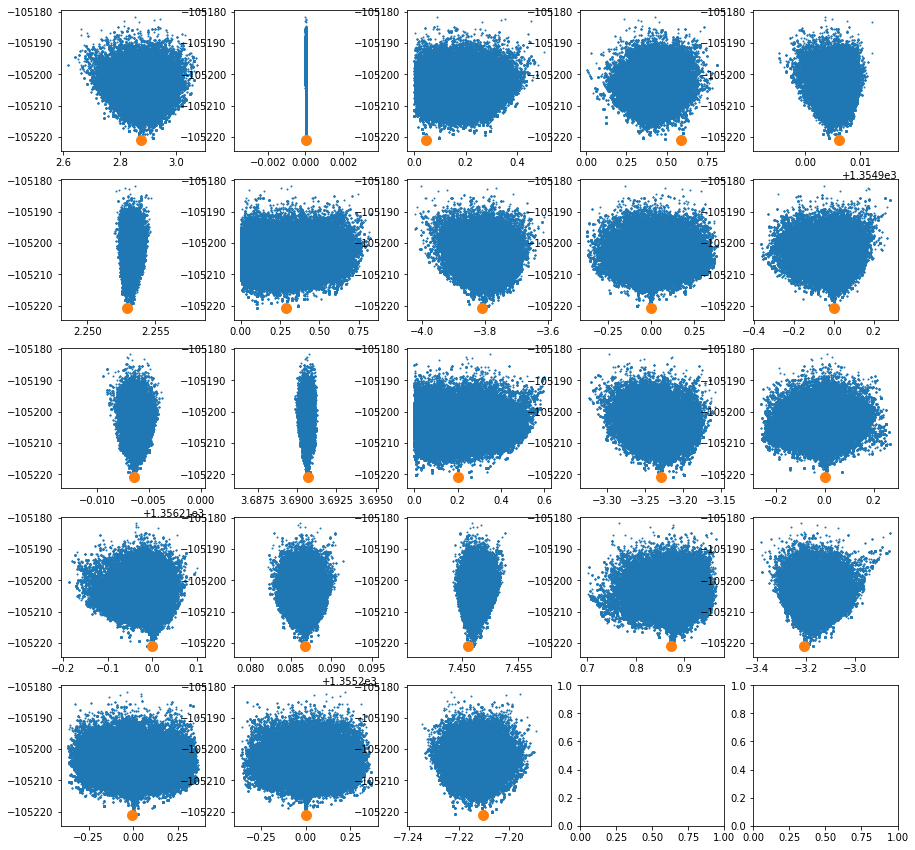

In [458]:
fig, axes = plt.subplots(5,5, figsize=[15,15])
axa = axes.flatten()
for idx in range(23):
    ax = axa[idx]
    ax.scatter(chains[:,2500:,idx].T.flatten(), -lnprob[:,2500:].T.flatten(), s=1)
    ax.scatter(chains[mle_idx][idx], -lnprob[mle_idx].T.flatten(), s=100)
#     plt.ylim(-104750,-105250)
#     ax.set_yscale("log")

In [459]:
chains[mle_idx]

array([  2.87512948e+00,   2.30056432e-05,   4.46062979e-02,
         5.86262922e-01,   1.35490615e+03,   2.25290658e+00,
         2.89570674e-01,  -3.80962430e+00,  -1.01202596e-04,
        -4.24104060e-04,   1.35620360e+03,   3.69070280e+00,
         2.00556261e-01,  -3.22881911e+00,   8.12932137e-04,
        -8.93195793e-04,   1.35528678e+03,   7.45054485e+00,
         8.73308033e-01,  -3.20968006e+00,  -9.40296670e-03,
         1.02905700e-03,  -7.21022564e+00])

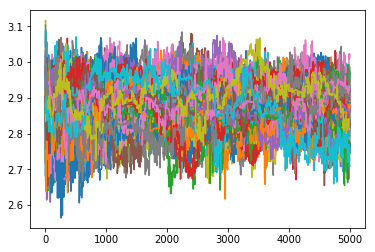

In [460]:
q = plt.plot(f['mcmc']['chain'][:,:,0].T)

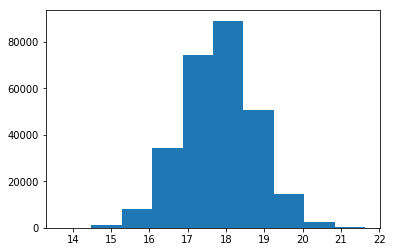

In [461]:
q = plt.hist(np.e**f['mcmc']['chain'][:,2500:,0].flatten(),)

In [462]:
vals= f['mcmc']['chain'][:,2500:,19].flatten().shape
np.percentile(
    np.e**f['mcmc']['chain'][:,2500:,7].flatten() *
    np.random.normal(0.291,0.025,size=vals) / 0.009155, 
    [15.9,50,84.1])

array([ 0.63764116,  0.70605675,  0.7771829 ])

In [463]:
[np.percentile(f['mcmc']['chain'][:,2500:,x].flatten() ,[15.9,50,84.1]) for x in range(23)]

[array([ 2.82528639,  2.88060635,  2.93046058]),
 array([  8.17123509e-06,   2.08244953e-05,   2.82056768e-05]),
 array([ 0.08665126,  0.16827562,  0.26012113]),
 array([ 0.33074951,  0.41919698,  0.51255758]),
 array([ 1354.90325575,  1354.90489143,  1354.9068972 ]),
 array([ 2.25287289,  2.25317108,  2.25345068]),
 array([ 0.11074293,  0.29296468,  0.48266186]),
 array([-3.85527284, -3.80539145, -3.75760133]),
 array([-0.09191745,  0.00109777,  0.1237373 ]),
 array([-0.08830094, -0.00474366,  0.04648752]),
 array([ 1356.20318786,  1356.20368053,  1356.20416546]),
 array([ 3.69049314,  3.69064094,  3.69078798]),
 array([ 0.05204297,  0.16847335,  0.32184096]),
 array([-3.25479504, -3.23222563, -3.21197676]),
 array([-0.0685076 , -0.00166902,  0.04907134]),
 array([-0.04893215, -0.01034536,  0.01118964]),
 array([ 1355.28551033,  1355.28656178,  1355.28751091]),
 array([ 7.45066784,  7.45116042,  7.4517759 ]),
 array([ 0.83019749,  0.87559026,  0.90937615]),
 array([-3.22287571, -3.173

In [472]:
print(np.percentile(
    get_ar(f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,5]).flatten() *
        np.random.normal(0.291,0.025,size=vals) *0.00464913034,
    [15.9,50,84.1]))

print(np.percentile(
    get_ar(f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,11]).flatten() *
        np.random.normal(0.291,0.025,size=vals) *0.00464913034,
    [15.9,50,84.1]))

print(np.percentile(
    get_ar(f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,17]).flatten() *
        np.random.normal(0.291,0.025,size=vals) *0.00464913034,
    [15.9,50,84.1]))

[ 0.01133984  0.01241035  0.01347943]
[ 0.01576371  0.01725103  0.01872923]
[ 0.02517688  0.02754717  0.02990736]


In [475]:
print(np.percentile(
get_insol(
    np.random.normal(3500, 150, size=vals),
    get_ar(np.e**f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,5]).flatten()
), [15.9,50,84.1]))

print(np.percentile(
get_insol(
    np.random.normal(3500, 150, size=vals),
    get_ar(np.e**f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,11]).flatten()
), [15.9,50,84.1]))

print(np.percentile(
get_insol(
    np.random.normal(3500, 150, size=vals),
    get_ar(np.e**f['mcmc']['chain'][:,2500:,0], f['mcmc']['chain'][:,2500:,17]).flatten()
), [15.9,50,84.1]))

[ 18.47152738  22.09646371  26.22443624]
[  9.57271686  11.44143097  13.57150283]
[ 3.75043411  4.47985993  5.3215195 ]
